In [1]:
import psycopg2
from psycopg2 import OperationalError

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from IPython.display import HTML
import webbrowser

***
    
    Ligação à base de dados

***

In [2]:
conn = psycopg2.connect(
    host = "contratos-base-gov1.cf87yxnqgph8.eu-central-1.rds.amazonaws.com",
    port = 5432,
    #database = "contratosbasegov",
    user = "contratosbasegov",
    password = "8n9nyeTBFUyCcLJShNrZdPUai2KQkue4")

cur = conn.cursor()

***

    Executar este comando quando ocorrer um erro ao tentar realizar uma query

***

In [3]:
cur.execute('''ROLLBACK;''')

***

# Exploração do Data Set

***

    Nome das colunas

In [4]:
def col_names(table):
    '''
    Função que retorna os nomes das colunas de uma tabela
    
    Parâmetros : 
        - table : tabela de interesse

    return : 
        - pandas DataFrame : nomes das colunas
    '''

    cur = conn.cursor()
    cur.execute('''
                SELECT column_name
                FROM information_schema.columns
                WHERE table_name = %s;''', (table,))

    cnames = pd.DataFrame(cur.fetchall())
    #cnames = [row[0] for row in cur.fetchall()]
    return cnames

HTML(pd.DataFrame(col_names('contratos')).to_html(index=True))

,0
0,id
1,n_anuncio
2,anuncio_preco_base
3,anuncio_proposalDeadline
4,anuncio_cnccs
5,anuncio_contractingProcedureAliasID
6,anuncio_contractingProcedureId
7,anuncio_drPublicationDate
8,anuncio_dreNumber
9,anuncio_dreSeries


    Número de Contratos


In [5]:
def n_contracts(table):
    '''
    Retorna o número de contratos de uma tabela pertencente à base de dados

    Parâmetros : 
        - table : tabela de interesse

    return : 
        - int : número de contrato
    '''
    
    cur = conn.cursor()
    cur.execute('''
                SELECT COUNT(*) 
                FROM "{}"; '''.format(table))
    ncontract = cur.fetchone()[0]
    return ncontract

n_contracts("contratos")

200987

    Organizar Contratos por Tipo de Procedimento

In [6]:
cur = conn.cursor()
cur.execute('''
        SELECT tipo_procedimento, COUNT (tipo_procedimento)
        FROM "contratos"
        GROUP BY "tipo_procedimento"
        ORDER BY COUNT(tipo_procedimento) DESC;;''')

df = (pd.DataFrame(cur.fetchall()))
HTML(df.to_html(index=False))

0,1
Ajuste Direto Regime Geral,89882
Consulta Prévia,40331
Concurso público,28438
Ao abrigo de acordo-quadro (art.º 259.º),20624
Ao abrigo de acordo-quadro (art.º 258.º),5205
Ajuste direto simplificado,1011
"Ajuste direto simplificado ao abrigo da Lei n.º 30/2021, de 21.05",919
Consulta Prévia Simplificada,435
Concurso limitado por prévia qualificação,297
Procedimento de negociação,25


In [15]:
cur = conn.cursor()

cur.execute('''
        SELECT "contractTypes", COUNT ("contractTypes")
        FROM "contratos"
        WHERE tipo_procedimento = 'Ajuste Direto Regime Geral'
        GROUP BY "contractTypes"
        ORDER BY  COUNT("contractTypes") DESC;;''')

df = (pd.DataFrame(cur.fetchall()))
HTML(df.to_html(index=False))

0,1
Aquisição de serviços,30502
Aquisição de bens móveis,28304
Empreitadas de obras públicas,2212
Locação de bens móveis,621
Aquisição de serviços<br/>Aquisição de bens móveis,212
Aquisição de bens móveis<br/>Aquisição de serviços,192
Concessão de obras públicas,31
Concessão de serviços públicos,29
Aquisição de serviços<br/>Locação de bens móveis,24
Locação de bens móveis<br/>Aquisição de serviços,19


In [34]:
def h(df):
    """
    Função que permite ver dataframe completa e de forma mais organizada
    """
    return HTML(df.to_html(index=False))

***

# Funções


***

    ID's dos contratos

In [6]:
def all_ids(table):
    '''
    Função que retorna todos os ids dos contratos de uma tabela

    Parâmetros :    
        - table : tabela de interesse

    Return : 
        - list : ids de todos os contratos de uma tabela 
    '''

    cur = conn.cursor()
    cur.execute(''' 
                SELECT id
                FROM "{}"; '''.format(table)) 
    return list(cur.fetchall())


ids = all_ids("contratos")

    ID's dos diferentes tipos de procedimentos

    1. Ajuste Direto Regime Geral

In [7]:
def ajuste_dir():
    """
    """
    
    cur = conn.cursor()
    
    cur.execute('''
            SELECT "id"
            FROM "contratos"
            WHERE tipo_procedimento = 'Ajuste Direto Regime Geral';''')
    
    return list(cur.fetchall())

    2. Consulta Prévia

In [8]:
def consulta_prev():
    """
    """
    
    cur = conn.cursor()
    
    cur.execute('''
            SELECT "id"
            FROM "contratos"
            WHERE tipo_procedimento = 'Consulta Prévia';''')
    
    return list(cur.fetchall())

    3. Concurso Público

In [9]:
def concurso_pub():
    """
    """
    
    cur = conn.cursor()
    
    cur.execute('''
            SELECT "id"
            FROM "contratos"
            WHERE tipo_procedimento = 'Concurso público';''')
    
    return list(cur.fetchall())

    Restringir por CPV - 72 IT services: consulting, software development, Internet and support

In [10]:
cur = conn.cursor()
cur.execute('''
            SELECT "id"
            FROM "contratos"
            WHERE cpv LIKE '72%';''')

len(cur.fetchall())

7723

In [11]:
def cpv_direto(cpv):
    
    """
    Função que retorna os id's de todos os contratos para um determinado CPV para todos os Ajustes Diretos em Regime Geral

    Parâmetros :
        cpv : inserir os dois algarismos iniciais do CPV entre '' ( https://www.publictendering.com/cpv-codes/list-of-the-cpv-codes/ )
    
    Return :
        tuple : id's dos contratos
    """
    
    cur = conn.cursor()
    cur.execute('''
                SELECT "id"
                FROM "contratos"
                WHERE cpv LIKE %s AND tipo_procedimento = 'Ajuste Direto Regime Geral';''', (cpv + '%',))
    
    return cur.fetchall()

In [12]:
def cpv_cpub(cpv):

    """
    Função que retorna os id's de todos os contratos para um determinado CPV para todos os Concursos Públicos

    Parâmetros :
        cpv : inserir os dois algarismos iniciais do CPV entre '' ( https://www.publictendering.com/cpv-codes/list-of-the-cpv-codes/ )
    
    Return :
        tuple : id's dos contratos
    """
    
    cur = conn.cursor()
    cur.execute('''
                SELECT "id"
                FROM "contratos"
                WHERE cpv LIKE %s AND tipo_procedimento = 'Concurso público';''', (cpv + '%',))

    
    return cur.fetchall()

In [13]:
def cpv(cpv, proc):

    """
    Função que retorna os id's de todos os contratos para um determinado CPV para todos os Concursos Públicos

    Parâmetros :
        cpv : inserir os dois algarismos iniciais do CPV entre '' ( https://www.publictendering.com/cpv-codes/list-of-the-cpv-codes/ )
    
    Return :
        tuple : id's dos contratos
    """
    
    cur = conn.cursor()
    cur.execute('''
                SELECT "id"
                FROM "contratos"
                WHERE cpv LIKE %s AND tipo_procedimento = %s;''', (cpv + '%', proc))

    
    return cur.fetchall()

In [14]:
ajdir = cpv('72','Ajuste Direto Regime Geral')
cpub = cpv('72', 'Concurso público')

    Função que retorna contrato para número de id

In [15]:
def contrato(ide):
    '''
    Função que retorna linha da database referente ao contrato com id = ide
    '''
        
    cur = conn.cursor()
    cur.execute('''
        SELECT *
        FROM "contratos"
        WHERE id = %s; ''', (ide,))
    return pd.DataFrame(cur.fetchall())


def contratos(ide):
    '''
    Função que retorna contratos referentes a um conjunto de ids

    Parâmetros :
        ide : tuplo de id's de anúncios

    return:
        dataframe com contratos
    '''
        
    cur = conn.cursor()
    cur.execute('''
        SELECT *
        FROM "contratos"
        WHERE id IN %s; ''', (tuple(ide),))
    return pd.DataFrame(cur.fetchall())

    Função que retorna contratos a partir do número do anúncio

In [16]:
cur = conn.cursor()
cur.execute('''
            SELECT * 
            FROM "contratos"
            WHERE "n_anuncio" = '8223/2023';''')

(cur.fetchall())

[('10332117',
  '8223/2023',
  '3139486.56',
  '30',
  'False',
  '6506218',
  '13041258',
  '2023-05-22',
  '98',
  '2',
  'False',
  'False',
  'https://dre.pt/application/file/213330772',
  'Anúncio de procedimento',
  'Concurso público',
  'Serviços de consultoria para serviços de integração (PRR) - Lote 2 - Serviços de produção de especificações técnicas e de domínio da informação',
  '2023-11-08',
  '2023-11-03',
  '557776.80',
  '420',
  'SPMS - Serviços Partilhados do Ministério da Saúde, E. P. E. (509540716)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=190896)',
  'Artigo 20.º, n.º 1, alínea a) do Código dos Contratos Públicos',
  'Sys-Match - Consultores de Sistemas de Informação, Lda (504665901)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=323846)',
  'IDW - Consultoria em Serviços de Informação, Lda (504243926)|||INDRA III  SOLUÇÕES  TECNOLOGIA (TECNOCOMPORT) (503222364)|||Capgemini Portugal, S.A. (504272179)|||Accenture - Consultores de Gestão

In [17]:
contrato('10230172')

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,10230172,8223/2023,3139486.56,30,False,6506218,13041258,2023-05-22,98,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,Plano de Recuperação e Resiliência (PRR) – art...,None,1701117163


In [18]:
def url(id):
    """
    Função que abre página web do anúncio a partir do id do contrato. Só funciona para um contrato de cada vez
    """
    
    cur = conn.cursor()

    cur.execute('''
        SELECT "url_anuncio"
        FROM "contratos"
        WHERE "id" = %s;''',(id, ))

    return webbrowser.open(cur.fetchall()[0][0])    

    Preço contratual

In [19]:
def preco_contrato1(ide):
    '''
    Função que retorna preço contratual a partir do id do anúncio para a tabela "contratos"

    Parâmetros :
        - ide : id do anúncio

    Return : 
        - int : preço contratual
    '''
        
    cur = conn.cursor()
    cur.execute('''
        SELECT preco_contratual
        FROM "contratos"
        WHERE id = %s; ''', (ide,))
    return float(cur.fetchone()[0])



# ---------------------------------------------------------------------------------------------------------------------------------------------------------



def preco_contrato2(ide, table = ""):
    '''
    Função que retorna preço contratual a partir do id do anúncio para um dada tabela

    Parâmetros :
        - ide : id do anúncio
        - table : tabela de interesse. Caso input esteja vazio, usar tabela 'contratos'

    Return : 
        - int : preço contratual
    '''

    if table == "": 
        table = "contratos"
        
    cur = conn.cursor()
    cur.execute('''
        SELECT preco_contratual
        FROM "{}"
        WHERE id = %s; '''.format(table), (ide,))
    return float((cur.fetchone())[0])


    
# ---------------------------------------------------------------------------------------------------------------------------------------------------------
    


#def preco_contrato3(id_anuncio):
#    
#    '''
#    Função que retorna preço contratual a partir de uma lista de ids de anúncios
#    '''
#    
#    cur.execute('''
#        SELECT preco_contratual
#        FROM "contratos"
#        WHERE id IN %s; ''', (tuple(id_anuncio),))
#    
#    return np.array(cur.fetchall()[0])

def preco_contrato3(id_anuncio):
    
    '''
    Função que retorna preço contratual a partir de uma lista de ids de anúncios
    '''
    
    cur.execute('''
        SELECT preco_contratual
        FROM "contratos"
        WHERE id IN %s; ''', (tuple(id_anuncio),))

   #preco = list(cur.fetchall())
   #
   #n = len(preco)
   #p = np.zeros(n)

   #for i in range(n):
   #    p[i] = (preco[i][0]).replace(".", "").replace(",",".").replace("€","")

    p = np.array(cur.fetchall(), dtype = float).reshape(len(id_anuncio),)
    return p


    
# ---------------------------------------------------------------------------------------------------------------------------------------------------------
    



def preco_contrato4(ide, table = ""):
    '''
    Função que retorna preço contratual a partir de uma lista de ids de anúncios para uma determinada tabela

    Parâmetros :
        - ide : id do anúncio
        - table : tabela de interesse. Caso input esteja vazio, usar tabela 'contratos'

    Return : 
        - int : preço contratual
    '''

    
    if table == "": 
        table = "contratos"

    
    cur.execute('''
        SELECT preco_contratual
        FROM "{}"
        WHERE id IN %s; '''.format(table), (tuple(ide),))
    
    return np.asarray(cur.fetchall())
    

    
# ---------------------------------------------------------------------------------------------------------------------------------------------------------

In [20]:
# sum(contratos(cpub).iloc[:,18].astype(float) - preco_contrato3(cpub))

    Preço Base

In [21]:
def preco_base(ide):
    '''
    Função que retorna preço base a partir do id do anúncio para a tabela "contratos"

    Parâmetros :
        - ide : id do anúncio

    Return : 
        - tuplo : preço contratual
    '''
        
    cur = conn.cursor()
    cur.execute('''
        SELECT anuncio_preco_base
        FROM "contratos"
        WHERE id = %s; ''', (ide,))
    
    return cur.fetchone()



def preco_base1(ide):
    '''
    Função que retorna preço base a partir do id do anúncio para a tabela "contratos"

    Parâmetros :
        - ide : id do anúncio

    Return : 
        - int : preço contratual
    '''
        
    cur = conn.cursor()
    cur.execute('''
        SELECT anuncio_preco_base
        FROM "contratos"
        WHERE id = %s; ''', (ide,))


    preco = cur.fetchone()[0]
    p1 = float(preco[:-2].replace(".", "").replace(",","."))
    
    return p1



# ---------------------------------------------------------------------------------------------------------------------------------------------------------



def preco_base2(ide, table = ""):
    '''
    Função que retorna preço base a partir do id do anúncio para um dada tabela

    Parâmetros :
        - ide : id do anúncio
        - table : tabela de interesse. Caso input esteja vazio, usar tabela 'contratos'

    Return : 
        - int : preço contratual
    '''

    if table == "": 
        table = "contratos"


    cur = conn.cursor()
    cur.execute('''
        SELECT anuncio_preco_base
        FROM "{}"
        WHERE id = %s; '''.format(table), (ide,))


    preco = cur.fetchone()[0]

    if preco != 0:
        p1 = float(preco[:-2].replace(".", "").replace(",","."))
    else:
        p1 = 0
    
    return p1
    


# ---------------------------------------------------------------------------------------------------------------------------------------------------------
    


def preco_base3(id_anuncio):
    
    '''
    Função que retorna preço base a partir de uma lista de ids de anúncios
    '''
    
    cur.execute('''
        SELECT anuncio_preco_base
        FROM "contratos"
        WHERE id IN %s; ''', (tuple(id_anuncio),))
    
    preco = list(cur.fetchall())
    #return preco    
    
    # Como os valores do preco base estão no formato ---.---,--€ é precio converter em -------.-- para comparar posteriormente
    n = len(preco)
    p = np.zeros(n)
    
    for i in range(n):
    
       if preco[i][0] != 'None':
           #p[i] = (preco[i][0]).replace(".00", "").replace(".", "").replace(",",".").replace("€","")
           p[i] = (preco[i][0])
    
       else:
           pass
           
    return p


In [22]:
#np.sum(contratos(cpub).iloc[:,2].astype(float) - preco_base3(cpub))

In [23]:
## Conjunto de todos os preços base
#a = preco_base3(ids)
#
##pd.DataFrame(a).describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))
#print("Nr de Zero Values :", len(a) - (np.count_nonzero(a)))
#print("Nr de Non Zero Values :", (np.count_nonzero(a)))
#print("% non zero values : ",round(np.count_nonzero(a)/len(a) * 100,1))

#nn_index = np.where(a != 0)[0]                 # índices dos ids dos contratos com preço base não nulo
#
#id1 = np.array(ids)                            # Transformação da lista de ids em array. Assim podemos extrair os ids não nulos usando os índices acima
#
#id2 = id1[nn_index]
#id2 = id2.reshape(len(id2),1)
#
#ids_nn = tuple(map(tuple, id2))                # ids não nulos. É preciso converter em tuplo para usar como input na função de preço base
#
#pb = preco_base3(ids_nn)
#pc = preco_contrato3(ids_nn)

***

    Lista de de Contratos Públicos
    
***

In [24]:
contratos(cpub)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,10001448,4840/2023,20000.00,6,False,6417636,12848310,2023-03-27,61,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,17999.09,1700348541
1,10004158,4270/2023,409500.00,39,False,6402336,12813822,2023-03-20,56,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1700350494
2,10005180,6923/2023,102200.00,6,False,6469692,12961360,2023-05-02,84,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,30525.00,1700350121
3,10005452,6114/2023,16000.00,6,False,6451422,12920559,2023-04-18,76,2,...,None,None,False,None,True,None,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1700350046
4,10007696,17004/2022,4118400.00,30,False,6216810,12474556,2022-12-22,245,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1700349450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,9996671,12066/2022,3264200.98,30,False,6078495,12189307,2022-09-23,185,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,Plano de Recuperação e Resiliência (PRR) – art...,None,1700341736
962,9996682,12066/2022,3264200.98,30,False,6078495,12189307,2022-09-23,185,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,Plano de Recuperação e Resiliência (PRR) – art...,None,1700341725
963,9997025,3618/2023,74997.91,6,False,6389157,12784140,2023-03-09,49,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1700347484
964,9997144,2440/2022,334000.00,11,False,6141159,12329725,2022-12-12,237,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL 111-B/2017) ...,None,None,1700347263


***

    Lista de Ajustes Diretos 

***

In [25]:
contratos(ajdir)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,10323628,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,N/A,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699382401
1,10323670,None,None,None,None,None,None,None,None,None,...,None,None,False,"Artigo 95.º, n.º 1, a), contrato de locação ou...",True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699382337
2,10324799,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699386139
3,10326169,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,None,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699385010
4,10322803,None,None,None,None,None,None,None,None,None,...,None,None,False,"Artigo 95.º, n.º 1, c), locação ou aquisição d...",True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699383587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4811,10270746,None,None,None,None,None,None,None,None,None,...,None,None,False,"Artigo 95.º, n.º 1, a), contrato de locação ou...",True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1701167533
4812,10270613,None,None,None,None,None,None,None,None,None,...,None,None,False,"Artigo 95.º, n.º 1, a), contrato de locação ou...",True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1701167642
4813,10270565,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1701167715
4814,10270513,None,None,None,None,None,None,None,None,None,...,None,None,True,"Artigo 95.º, n.º 1, a), contrato de locação ou...",True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1701167801


***

# Ajuste Direto Regime Geral

***

In [30]:
# ajdir são os id's dos contratos referentes a ajustes diretos
# ajustesdir é uma dataframe que contém todas as colunas da DB referentes a ajustes diretos
ajustesdir = contratos(ajdir)

# Renomear colunas dos preços base e contratual
ajustesdir = ajustesdir.rename(columns={18:'PrecoContratual', 38:'TipoProcedimento'})

# Conversão dos precos contratuais para float a fim de os comparar aos preços base
ajustesdir.PrecoContratual = ajustesdir.iloc[:,18].astype('float')

# Sumário Estatístico dos Preços contratuais
ajustesdir.PrecoContratual.describe().apply(lambda x: format(x, '.2f'))

count       2927.00
mean       35439.28
std       190075.68
min           51.00
25%         7500.00
50%        13500.00
75%        20000.00
max      8624000.00
Name: PrecoContratual, dtype: object

In [31]:
ajdir[0]

('9905751',)

In [32]:
h(ajustesdir.head(2))

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,PrecoContratual,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,TipoProcedimento,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
10323628,None,None,None,None,None,None,None,None,None,None,None,None,None,Ajuste Direto Regime Geral,Serviço Via Verde Estacionar,2023-11-02,2023-10-20,19990.0,731,"Loures Parque - Empresa Municipal de Estacionamento, E. M., Unipessoal, L.da (505072947)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=4381)","Artigo 20.º, n.º 1, alínea d) do Código dos Contratos Públicos","Via Verde Portugal ? Gestão de Sistemas Eletrónicos de Cobrança, S.A. (504656767)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=31977)",None,None,None,https://www.base.gov.pt/Base4/pt/resultados/?type=doc_documentos&id=2071227&ext=.pdf,false,72000000-5,False,None,None,False,False,None,False,None,False,Aquisição de serviços,"Serviços de TI: consultoria, desenvolvimento de software, Internet e apoio",Principal,19990.0,Ajuste Direto N.º 08/23 - Serviço Via Verde Estacionar,Não aplicável,None,"Portugal, Lisboa, Loures",Não aplicável.,Não aplicável.,None,False,False,None,None,False,None,True,N/A,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699382401
10270927,None,None,None,None,None,None,None,None,None,None,None,None,None,Ajuste Direto Regime Geral,DIR@2020 (POCI-05-5762-FSE-000412) INTERFACE HLTSYS_ADMINSAUDE - RASTREABILIDADE E AUTENTICAÇÃO,2023-10-02,2023-10-02,10775.0,20,"Centro Hospitalar Tondela-Viseu, E. P. E. (509822940)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=287467)","Artigo 24.º, n.º 1, alínea e), subalínea ii) do Código dos Contratos Públicos","HLTSYS - HEALTHSYSTEMS, LDA (510552544)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=1637342)",None,None,None,None,false,72212610-8,False,None,None,False,False,None,False,None,False,Aquisição de serviços,Serviços de desenvolvimento de software para bases de dados,Principal,10775.0,DIR@2020 (POCI-05-5762-FSE-000412) INTERFACE HLTSYS_ADMINSAUDE - RASTREABILIDADE E AUTENTICAÇÃO,Não aplicável,None,"Portugal, Viseu, Viseu",Não aplicável.,Não aplicável.,None,False,False,None,None,True,"Artigo 95.º, n.º 1, c), locação ou aquisição de bens móveis ou de serviços nos termos das alíneas i),ii),iii),cumulativamente",True,None,"Código dos Contratos Públicos (DL111-B/2017) e Lei n.º 30/2021, de 21.05",None,None,1699468541


In [33]:
ajustesdir.TipoProcedimento.value_counts()

TipoProcedimento
Aquisição de serviços                                       2901
Aquisição de bens móveis<br/>Aquisição de serviços            14
Aquisição de serviços<br/>Aquisição de bens móveis             6
Locação de bens móveis<br/>Aquisição de serviços               2
Concessão de serviços públicos                                 2
Aquisição de serviços<br/>Empreitadas de obras públicas        1
Concessão de serviços públicos<br/>Aquisição de serviços       1
Name: count, dtype: int64

/home/francisco/MECAD/COMP/comp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/francisco/MECAD/COMP/comp/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='PrecoContratual', ylabel='Count'>

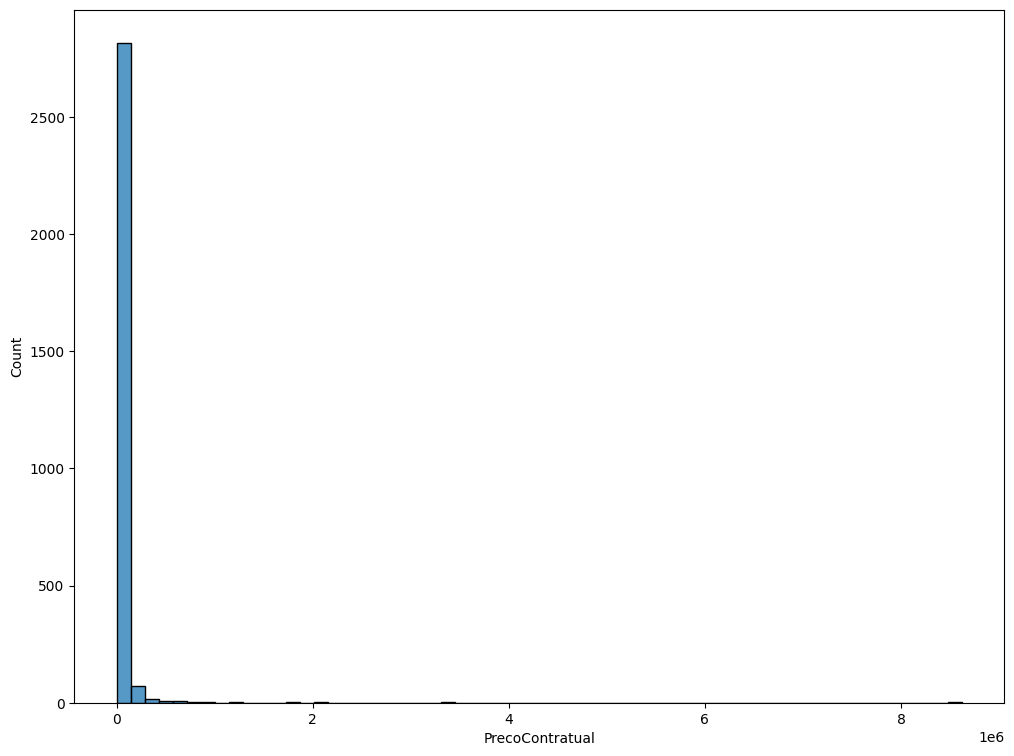

In [34]:
plt.figure(figsize=(12,9))
sns.histplot(ajustesdir.PrecoContratual, bins = 60)

<Axes: >

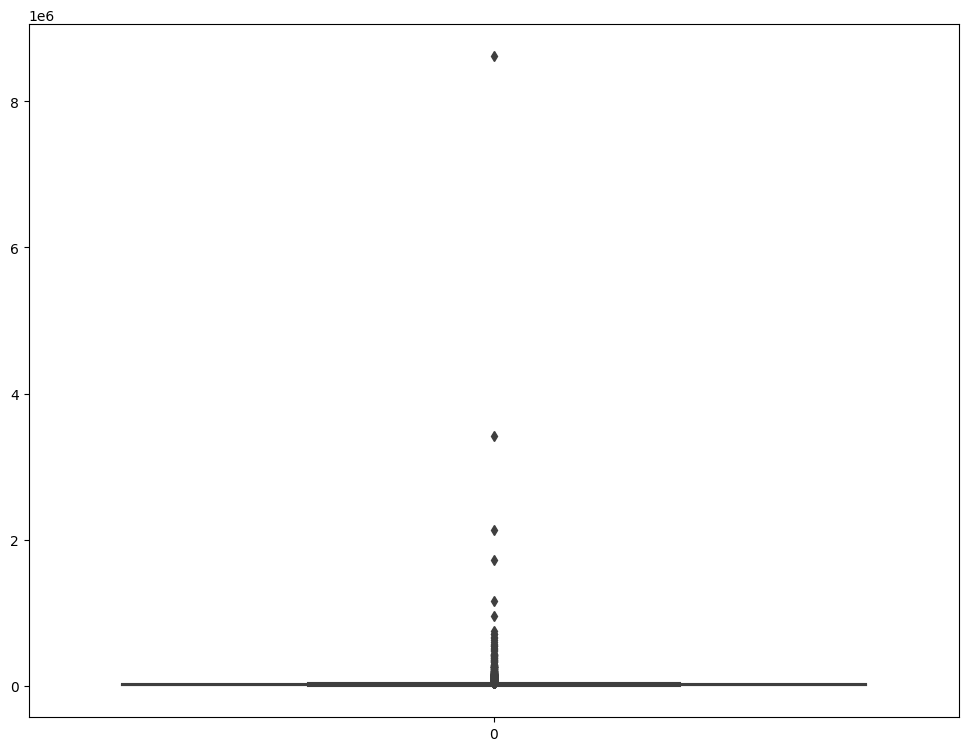

In [35]:
plt.figure(figsize=(12,9))
sns.boxplot(ajustesdir.PrecoContratual)


In [36]:
# Conjunto de fundamentações para ajustes diretos por ordem decrescente de ocorrência
(ajustesdir).groupby(21).size().sort_values(ascending = False)

21
Artigo 20.º, n.º 1, alínea d) do Código dos Contratos Públicos                                                     1510
Artigo 24.º, n.º 1, alínea e), subalínea iii) do Código dos Contratos Públicos                                      588
Artigo 24.º, n.º 1, alínea e), subalínea ii) do Código dos Contratos Públicos                                       558
Artigo 20.º, n.º 1, alínea d) do Código dos Contratos Públicos e artigo 4.º, nº 1 do DLR nº 34/2008/M, de 14.08      63
Artigo 24.º, n.º 1, alínea c) do Código dos Contratos Públicos                                                       56
Artigo 20.º, alínea a) do Decreto Legislativo Regional n.º 27/2015/A, de 29.12                                       51
Artigo 24.º, n.º 1, alínea e), subalínea i) do Código dos Contratos Públicos                                         16
Artigo 21.º, n.º 1, alínea c) do Código dos Contratos Públicos                                                       14
Artigo 24.º, n.º 1, alínea a) do Códi

In [37]:
#HTML(ajustesdir.to_html(index = False))

In [38]:
# Valor máximo de um ajuste direto é mais de 3.000.000,00€

# Índice do array do valor mais alto 
print(np.where(ajustesdir.PrecoContratual > 3000000)[0])

# ID do contrato correspondente
# ajdir[30]

HTML((contrato(ajdir[30])).to_html(index=True))

[  30 2136]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,9977543,None,None,None,None,None,None,None,None,None,None,None,None,None,Ajuste Direto Regime Geral,AQUISIÇÃO DE SERVIÇOS DE MANUTENÇÃO DO ERP AIRC E PLATAFORMA MYNET,2023-05-09,2023-04-28,51081.00,366,Câmara Municipal de Sesimbra (501144218)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=1473),"Artigo 24.º, n.º 1, alínea e), subalínea ii) do Código dos Contratos Públicos",AIRC - Associação Informática da Região Centro (501378669)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=2132),None,None,https://community.vortal.biz/PRODPublic/Tendering/OpportunityDetail/Index?noticeUID=PT1.NTC.2188764,https://www.base.gov.pt/Base4/pt/resultados/?type=doc_documentos&id=1994567&ext=.pdf,false,72260000-5,False,None,None,False,False,None,False,None,False,Aquisição de serviços,Serviços relacionados com software,Principal,51081.0,45/2022 - GTSI,ausência de recursos próprios,None,"Portugal, Setúbal, Sesimbra",Não aplicável.,Não aplicável.,None,False,False,None,None,False,None,True,None,"Código dos Contratos Públicos (DL111-B/2017) e Lei n.º 30/2021, de 21.05",None,None,1700319900


In [39]:
# ID's dos contratos com fla
rflag = redflag2(ajustesdir, ajdir)

NameError: name 'redflag2' is not defined

In [40]:
# Ajustes Diretos com preço contratual superior a 20.000€
h(contratos(redflag2(ajustesdir, ajdir)).head(2))

NameError: name 'redflag2' is not defined

In [41]:
print('Nr de Ajustes Diretos :', len(ajustesdir))
print('Nr de Ajustes Diretos Suspeitos :', len(contratos(redflag2(ajustesdir, ajdir))))
print('% = ', round(len(contratos(redflag2(ajustesdir, ajdir)))/len(ajustesdir), 3)*100 )

Nr de Ajustes Diretos : 2927


NameError: name 'redflag2' is not defined

In [50]:
# As colunas da dataframe de entidade adjudicante e entidade adjudicataria vão ser decompostas em 3 novas colunas: Entidade-NIF-URL
ajustesdir = ajustesdir.rename(columns={20: 'Adjudicante', 21:'Fundamentação', 22:'Adjudicatária'})


# Separação dos elementos de cada coluna em Entidade-NIF-URL
# O objetivo é contar o número de ocorrências de cada NIF
pattern = r'^(?P<EntidadeAdjudicante>.*?)\s?\((?P<NIF1>[\w\.-]+)\)\((?P<URL1>.*?)\)$'
pattern1 = r'^(?P<EntidadeAdjudicataria>.*?)\s?\((?P<NIF2>[\w\.-]+)\)\((?P<URL2>.*?)\)$'


Df_extracted = ajustesdir['Adjudicante'].str.extract(pattern)
Df_extracted1 = ajustesdir['Adjudicatária'].str.extract(pattern1)


# Correr linhas abaixo só uma vez
# Caso contrário está sempre a adicionar à dataframe as mesas colunas
ajustesdir = pd.concat([ajustesdir, Df_extracted], axis=1)
ajustesdir = pd.concat([ajustesdir, Df_extracted1], axis=1)


h(ajustesdir.head(2))

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,PrecoContratual,19,Adjudicante,Fundamentação,Adjudicatária,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,TipoProcedimento,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,EntidadeAdjudicante,NIF1,URL1,EntidadeAdjudicataria,NIF2,URL2
10323628,None,None,None,None,None,None,None,None,None,None,None,None,None,Ajuste Direto Regime Geral,Serviço Via Verde Estacionar,2023-11-02,2023-10-20,19990.0,731,"Loures Parque - Empresa Municipal de Estacionamento, E. M., Unipessoal, L.da (505072947)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=4381)","Artigo 20.º, n.º 1, alínea d) do Código dos Contratos Públicos","Via Verde Portugal ? Gestão de Sistemas Eletrónicos de Cobrança, S.A. (504656767)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=31977)",None,None,None,https://www.base.gov.pt/Base4/pt/resultados/?type=doc_documentos&id=2071227&ext=.pdf,false,72000000-5,False,None,None,False,False,None,False,None,False,Aquisição de serviços,"Serviços de TI: consultoria, desenvolvimento de software, Internet e apoio",Principal,19990.0,Ajuste Direto N.º 08/23 - Serviço Via Verde Estacionar,Não aplicável,None,"Portugal, Lisboa, Loures",Não aplicável.,Não aplicável.,None,False,False,None,None,False,None,True,N/A,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699382401,"Loures Parque - Empresa Municipal de Estacionamento, E. M., Unipessoal, L.da",505072947,https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=4381,"Via Verde Portugal ? Gestão de Sistemas Eletrónicos de Cobrança, S.A.",504656767,https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=31977
10270927,None,None,None,None,None,None,None,None,None,None,None,None,None,Ajuste Direto Regime Geral,DIR@2020 (POCI-05-5762-FSE-000412) INTERFACE HLTSYS_ADMINSAUDE - RASTREABILIDADE E AUTENTICAÇÃO,2023-10-02,2023-10-02,10775.0,20,"Centro Hospitalar Tondela-Viseu, E. P. E. (509822940)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=287467)","Artigo 24.º, n.º 1, alínea e), subalínea ii) do Código dos Contratos Públicos","HLTSYS - HEALTHSYSTEMS, LDA (510552544)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=1637342)",None,None,None,None,false,72212610-8,False,None,None,False,False,None,False,None,False,Aquisição de serviços,Serviços de desenvolvimento de software para bases de dados,Principal,10775.0,DIR@2020 (POCI-05-5762-FSE-000412) INTERFACE HLTSYS_ADMINSAUDE - RASTREABILIDADE E AUTENTICAÇÃO,Não aplicável,None,"Portugal, Viseu, Viseu",Não aplicável.,Não aplicável.,None,False,False,None,None,True,"Artigo 95.º, n.º 1, c), locação ou aquisição de bens móveis ou de serviços nos termos das alíneas i),ii),iii),cumulativamente",True,None,"Código dos Contratos Públicos (DL111-B/2017) e Lei n.º 30/2021, de 21.05",None,None,1699468541,"Centro Hospitalar Tondela-Viseu, E. P. E.",509822940,https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=287467,"HLTSYS - HEALTHSYSTEMS, LDA",510552544,https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=1637342


In [51]:
counts = ajustesdir.groupby('NIF1').size().reset_index(name='Count')
counts1 = ajustesdir.groupby('NIF2').size().reset_index(name='Count')

# Entidades Adjudicantes com mais ajustes diretos celebrados
h(counts.sort_values(by = ['Count'], ascending=False))

NIF1,Count
502017368,43
501559094,28
509822940,24
500225680,24
509540716,24
506361470,22
507618319,21
516726862,20
501413197,20
506361390,20


In [52]:
# Entidades Adjudicatárias com mais ajustes diretos celebrados
h(counts1.sort_values(by = ['Count'], ascending=False))

NIF2,Count
-,152
501378669,68
505331187,51
502479418,47
504615947,37
504990926,35
504551221,28
503754803,28
511135610,26
501989978,25


In [53]:
C1 = counts.sort_values(by = ['Count'], ascending=False)
C2 = counts1.sort_values(by = ['Count'], ascending=False)

In [54]:
def e_adjudicante(df,nif):
    """
    Função que retorna id's dos contratos a partir do NIF da entidade adjudicante

    Parâmetros:
        df : dataframe. Neste caso terá de ser a dataframe chamada ajustesdir porque já sofreu alterações, tais como, a inserção de colunas para os NIF's e etc
        nif : NIF da entidade

    return:
        ids dos ajustes diretos celebrados para a entidade adjudicante com o NIF em questão
    """

    index = (np.where(df.NIF1 == nif)[0])
    ids = np.array(df.iloc[index,0])

    ids = ids.reshape((len(ids),1))
    ids = tuple(map(tuple,ids))
    
    return ids



def e_adjudicataria(df,nif):
    """
    Função que retorna id's dos contratos a partir do NIF da entidade adjudicatária

    Parâmetros:
        df : dataframe. Neste caso terá de ser a dataframe chamada ajustesdir porque já sofreu alterações, tais como, a inserção de colunas para os NIF's e etc
        nif : NIF da entidade

    return:
        ids dos ajustes diretos celebrados para a entidade adjudicatária com o NIF em questão
    """

    index = (np.where(df.NIF2 == nif)[0])
    ids = np.array(df.iloc[index,0])

    ids = ids.reshape((len(ids),1))
    ids = tuple(map(tuple,ids))
    
    return ids

In [55]:
def entidadeI(df,nif):
    """
    Função que retorna nome da entidade adjudicante a partir do NIF
    
    Parâmetros:
        df : dataframe. Neste caso terá de ser a dataframe chamada ajustesdir porque já sofreu alterações, tais como, a inserção de colunas para os NIF's e etc
        nif : NIF da entidade

    return:
        nome da entidade
    """

    index = (np.where(df.NIF1 == nif)[0])
    i = index[0]
    
    return df.EntidadeAdjudicante[i]



def entidadeII(df,nif):
    """
    Função que retorna nome da entidade adjudicatária a partir do NIF
    
    Parâmetros:
        df : dataframe. Neste caso terá de ser a dataframe chamada ajustesdir porque já sofreu alterações, tais como, a inserção de colunas para os NIF's e etc
        nif : NIF da entidade

    return:
        nome da entidade
    """

    index = (np.where(df.NIF2 == nif)[0])
    i = index[0]
    
    return df.EntidadeAdjudicataria[i]

In [56]:
# PARA ENTIDADES ADJUDICANTES

# Este array vai servir para guardar o número de ajustes diretos suspeitos para cada NIF
# O NIF com mais ajustes diretos está na posição 0 do array, o segundo na posição 1 e assim sucessivamente
# Neste caso, o número de ajustes diretos suspeitos referentes à empresa com mais ajustes diretos realizados está na posição 0
ents = np.zeros(len(C1.NIF1))

# Lista com os nomes das entidades adjudicantes
name = list()

# Lista que vai conter o número de ajustes diretos realizados para cada entidade
cel  = np.zeros(len(C1.NIF1))


for i,j in enumerate(C1.NIF1):

    # Nome da entidade adjudicante
    name.append(entidadeI(ajustesdir, j))

    # ID's dos ajustes diretos celebrados
    x = e_adjudicante(ajustesdir,j)

    # Número de ajustes diretos celebrados
    cel[i] = len(x)
    
    for k in x:
        if k in rflag:
            ents[i] += 1        

# Percentagem de contratos suspeitos
perc = np.round(ents/cel*100,2)

newdf = pd.DataFrame({'EntidadeAdjudicante': name, 'NIF':C1.NIF1, 'Celebrados': cel, 'Suspeitos': ents, '%':perc})
h(newdf)

EntidadeAdjudicante,NIF,Celebrados,Suspeitos,%
Autoridade Nacional de Comunicações,502017368,43.0,9.0,20.93
Universidade Nova de Lisboa,501559094,28.0,5.0,17.86
"Centro Hospitalar Tondela-Viseu, E. P. E.",509822940,24.0,5.0,20.83
"Rádio e Televisão de Portugal, S. A.",500225680,24.0,4.0,16.67
"SPMS - Serviços Partilhados do Ministério da Saúde, E. P. E.",509540716,24.0,18.0,75.00
"Hospital Garcia de Orta, E. P. E.",506361470,22.0,14.0,63.64
"Centro Hospitalar de Lisboa Ocidental, EPE (CHLO)",507618319,21.0,6.0,28.57
"Hospital de Loures, E. P. E.",516726862,20.0,5.0,25.00
Universidade do Porto,501413197,20.0,3.0,15.00
"Unidade Local de Saúde de Matosinhos, E. P. E.",506361390,20.0,12.0,60.00


In [57]:
# PARA ENTIDADES ADJUDICATÁRIAS

# Este array vai servir para guardar o número de ajustes diretos suspeitos para cada NIF
# O NIF com mais ajustes diretos está na posição 0 do array, o segundo na posição 1 e assim sucessivamente
# Neste caso, o número de ajustes diretos suspeitos referentes à empresa com mais ajustes diretos realizados está na posição 0
ents1 = np.zeros(len(C2.NIF2))

# Lista com os nomes das entidades adjudicatárias
name1 = list()

# Lista que vai conter o número de ajustes diretos realizados para cada entidade
cel1  = np.zeros(len(C2.NIF2))


for i,j in enumerate(C2.NIF2):
    
    # Nome da entidade adjudicante
    name1.append(entidadeII(ajustesdir, j))

    # ID's dos ajustes diretos celebrados
    x1 = e_adjudicataria(ajustesdir,j)

    # Número de ajustes diretos celebrados
    cel1[i] = len(x1)
    
    for k in x1:
        if k in rflag:
            ents1[i] += 1        

# Percentagem de contratos suspeitos
perc1 = np.round(ents1/cel1*100,2)

newdf1 = pd.DataFrame({'EntidadeAdjudicatárias': name1, 'NIF':C2.NIF2, 'Celebrados': cel1, 'Suspeitos': ents1, '%':perc1})
h(newdf1)

EntidadeAdjudicatárias,NIF,Celebrados,Suspeitos,%
Vítor José Cardoso Parada,-,152.0,3.0,1.97
AIRC - Associação de Informatica da Região Centro,501378669,68.0,38.0,55.88
WireMaze - Sistemas de Informação S.A.,505331187,51.0,9.0,17.65
"GLINTT - HEALTHCARE SOLUTIONS, SA.",502479418,47.0,26.0,55.32
"MEO - Serviços de Comunicações e Multimédia, S. A.",504615947,37.0,6.0,16.22
Medidata,504990926,35.0,19.0,54.29
"Link Consulting - Tecnologias de Informação, S.A.",504551221,28.0,11.0,39.29
"Recursos, Ideias e Soluções Informáticas, Lda.",503754803,28.0,8.0,28.57
"ACIN-ICLOUD Solutions, Lda.",511135610,26.0,1.0,3.85
Quidgest-Consultores de Gestão S.A.,501989978,25.0,12.0,48.00


In [58]:
n1 = np.array(ajustesdir.NIF1)
n2 = np.array(ajustesdir.NIF2)

print('Número de Ajustes Diretos :', len(n1))
print('Número de NIFs de entidades adjudicantes :', len(C1)) 
print('Número de NIFs de entidades adjudicatárias :', len(C2)) 

Número de Ajustes Diretos : 2650
Número de NIFs de entidades adjudicantes : 862
Número de NIFs de entidades adjudicatárias : 1022


# Plots

In [35]:
cur = conn.cursor()
cur.execute('''
            SELECT column_name
            FROM information_schema.columns
            WHERE table_name = 'contratos';''')

h(pd.DataFrame(cur.fetchall()))

0
id
n_anuncio
anuncio_preco_base
anuncio_proposalDeadline
anuncio_cnccs
anuncio_contractingProcedureAliasID
anuncio_contractingProcedureId
anuncio_drPublicationDate
anuncio_dreNumber
anuncio_dreSeries


In [43]:
cur = conn.cursor()
cur.execute('''
            SELECT data_publicacao 
            FROM "contratos"
            WHERE EXTRACT(YEAR FROM data_publicacao) = 2022;''')

h(pd.DataFrame(cur.fetchall()))

UndefinedFunction: function pg_catalog.extract(unknown, text) does not exist
LINE 4:             WHERE EXTRACT(YEAR FROM data_publicacao) = 2022;
                          ^
HINT:  No function matches the given name and argument types. You might need to add explicit type casts.


(28951,)

In [66]:
def contracts_year(Y):

    cur = conn.cursor()
    cur.execute('''
                SELECT COUNT(*) 
                FROM "contratos"
                WHERE EXTRACT(YEAR FROM data_publicacao::timestamp) = %s;''', (Y,))
    
    return cur.fetchone()[0]

In [97]:
def pcontratual_ano(year):
    cur = conn.cursor()
    cur.execute('''
                SELECT SUM(CAST(preco_contratual AS FLOAT))
                FROM "contratos"
                WHERE EXTRACT(YEAR FROM data_publicacao::timestamp) = %s;''', (year,))
    
    return cur.fetchone()[0]

In [103]:
C2023 = contracts_year(2023)
P2023 = pcontratual_ano(2023)

C2022 = contracts_year(2022)
P2022 = pcontratual_ano(2022)

In [111]:
print(C2023,P2023,C2022,P2022)

172036 13629228277.570015 28951 1926885901.6900034


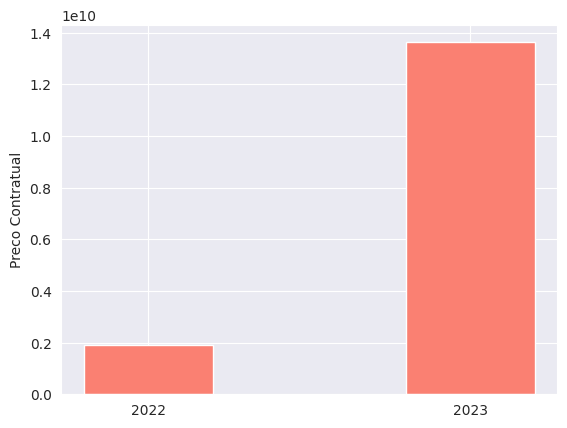

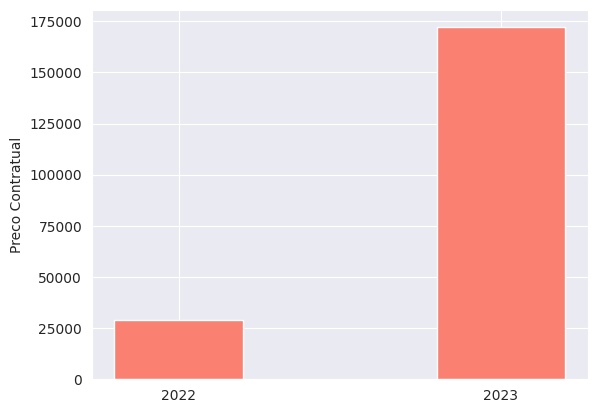

In [162]:
anos = np.array([2022, 2023])
prices = np.array([P2022,P2023])
contracts = np.array([C2022,C2023])

plt.bar(anos, prices, tick_label = [2022,2023], width = .4, align = 'center', color = 'salmon')
plt.ylabel('Preco Contratual')
plt.show()

plt.bar(anos, contracts, tick_label = [2022,2023], width = .4, align = 'center', color = 'salmon')
plt.ylabel('Preco Contratual')
plt.show()